In [1]:
from BiasedErasure.delayed_erasure_decoders.Experimental_Loss_Decoder import *
import numpy as np
# num_rounds = 5
num_layers = 2
num_cxs_per_round = 10
distance = 3
decoder_basis = 'XX'
gate_ordering = ['N', 'Z']
noise_params = {'idle_loss_rate': 2.793300220405646e-07, 'idle_error_rate': np.array([6.60547942e-09, 3.38336163e-08, 2.67533789e-07]),
                'entangling_zone_error_rate': np.array([3.66476387e-04, 6.14732819e-06, 2.35857048e-03]),
                'entangling_gate_error_rate': [2.2260729018707513e-05, 0.00017139584089578063, 0.0012948317242757047, 2.2260729018707513e-05, 0, 0, 0, 0.00017139584089578063, 0, 0, 0, 0.0012948317242757047, 0, 0, 0.002621736717313752],
                'entangling_gate_loss_rate': 0.00039272255674060926, 'single_qubit_error_rate': np.array([1.53681034e-05, 9.93583065e-04, 1.94650113e-05]),
                'reset_error_rate': 5.89409983290463e-05, 'measurement_error_rate': 0.0006138700821647161, 'reset_loss_rate': 0.0007531131027610011, 'measurement_loss_rate': 0.07131074481520218, 'ancilla_idle_loss_rate': 1.6989311035347498e-07,
                'ancilla_idle_error_rate': np.array([1.46727589e-07, 4.60893305e-08, 2.30298714e-06]), 'ancilla_reset_error_rate': 0.024549181355318986, 'ancilla_measurement_error_rate': 0.0012815874700447462, 'ancilla_reset_loss_rate': 0.00019528486460263086, 'ancilla_measurement_loss_rate': 0.00047357577582906143,
                'gate_noise': LogicalCircuit.ancilla_data_differentiated_gate_noise, 'idle_noise': LogicalCircuit.ancilla_data_differentiated_idle_noise}



Meta_params = {'architecture': 'CBQC', 'code': 'Rotated_Surface', 'logical_basis': decoder_basis,
            'bias_preserving_gates': 'False',
            'noise': 'atom_array', 'is_erasure_biased': 'False', 'LD_freq': '1000', 'LD_method': 'None',
            'SSR': 'True', 'cycles': str(num_layers - 1),
            'ordering': gate_ordering,
            'decoder': 'MLE',
            'circuit_type': f'logical_CX_NL{num_layers}_NCX{num_cxs_per_round}', 'Steane_type': 'None', 'printing': 'True', 'num_logicals': '2',
            'loss_decoder': 'independent',
            'obs_pos': 'd-1', 'n_r': '0'}



# Load the experimental measurements

simulate_data = True

if simulate_data:
    detection_events_signs = None
    exp_measurements = None
    num_shots = 1500

else:
    # Load the theory circuit
    _, _, _, circuit = get_simulated_measurement_events(Meta_params, distance, distance, 1, noise_params)
    # Use the theory circuit to get the detection events and observable flips corresponding to the exp data
    detection_events, observable_flips = circuit.compile_m2d_converter().convert(measurements=exp_measurements.astype(bool), separate_observables=True)
    # Find detection event signs
    detection_events_signs = -np.sign(2*np.nanmean(detection_events.astype(int), axis=0)-1).astype(int)
    exp_measurements = np.load(f'/Users/gefenbaranes/Documents/2024_10_15_measurement_events_1CNOT_XX.npy')
    exp_measurements = np.concatenate([exp_measurements[:, 0, :distance**2-1],
                                    exp_measurements[:, 1, :distance**2-1],
                                    exp_measurements[:, 0, distance**2-1:2*(distance**2-1)],
                                    exp_measurements[:, 1, distance**2-1:2*(distance**2-1)],
                                    exp_measurements[:, 0, 2*(distance**2-1):],
                                    exp_measurements[:, 1, 2*(distance**2-1):]], axis=1)


# Now let's decode!
use_loss_decoding = True  # if False: use same DEM every shot, without utilizing SSR.
use_independent_decoder = True  # if False: in every lifecycle, we just apply supercheck at the end. If True: we count the full lifecycle with different potential loss locations and corresponding Clifford propagations.
use_independent_and_first_comb_decoder = False  # This is relevant only if use_independent_decoder=True. If False: use only independent lifecycles. If True: adds a single combination of lifecycles to the decoder.
output_dir = '/Users/gefenbaranes/Documents/CX_experiment'
# DO IT
predictions, observable_flips, dems_list = Loss_MLE_Decoder_Experiment(Meta_params, distance, distance, output_dir,
                                                                    exp_measurements,
                                                                    detection_events_signs, use_loss_decoding,
                                                                    use_independent_decoder,
                                                                    use_independent_and_first_comb_decoder,
                                                                    simulate_data=simulate_data, logical_gaps=False,
                                                                    noise_params=noise_params, num_shots=num_shots)
logical_probability = np.mean(np.logical_xor(observable_flips, predictions))
print('/n logical error', logical_probability)


# error bar: (np.sqrt(P*(1-P)/num_shots))

num_layers = 2
num_CX_per_layer = 10
generating the Logical circuit took: 0.462691s
Logical circuit that will be used: 
R 1 2 3 7 8 9 13 14 15
X_ERROR(5.8941e-05) 1 2 3 7 8 9 13 14 15
I 1 2 3 7 8 9 13 14 15
SQRT_Y_DAG 1 3 8 13 15
PAULI_CHANNEL_1(1.53681e-05, 0.000993583, 1.9465e-05) 1 3 8 13 15
R 18 19 20 24 25 26 30 31 32
X_ERROR(5.8941e-05) 32 18 19 20 24 25 26 30 31
I 32 18 19 20 24 25 26 30 31
SQRT_Y_DAG 19 24 26 31
PAULI_CHANNEL_1(1.53681e-05, 0.000993583, 1.9465e-05) 19 24 26 31
SQRT_Y 2 7 9 14
PAULI_CHANNEL_1(1.53681e-05, 0.000993583, 1.9465e-05) 2 7 9 14
SQRT_Y 18 20 25 30 32
PAULI_CHANNEL_1(1.53681e-05, 0.000993583, 1.9465e-05) 18 20 25 30 32
PAULI_CHANNEL_1(1.3211e-06, 6.7667e-06, 5.35053e-05) 32 1 2 3 7 8 9 13 14 15 18 19 20 24 25 26 30 31
PAULI_CHANNEL_1(2.93451e-05, 9.21782e-06, 0.000460492)
I 32 1 2 3 7 8 9 13 14 15 18 19 20 24 25 26 30 31
CZ 1 18 2 19 3 20 7 24 8 25 9 26 13 30 14 31 15 32
PAULI_CHANNEL_2(2.22607e-05, 0.000171396, 0.00129483, 2.22607e-05, 0, 0, 0, 0.00017

KeyboardInterrupt: 

In [14]:
import re

num_layers = 20
num_cxs_per_round = 0
circuit_type = f'logical_CX_NL{num_layers}_NCX{num_cxs_per_round}'
num_layers, num_cxs_per_round = map(int, re.findall(r'\d+', circuit_type))
print(num_layers)
print(num_cxs_per_round)

20
0


In [2]:
1-logical_probability

0.9553333333333334

In [4]:
from BiasedErasure.delayed_erasure_decoders.Experimental_Loss_Decoder import *
import numpy as np


num_rounds = 3
num_cx = 3
distance = 5
decoder_basis = 'XX'
gate_ordering = ['N', 'Z']
exp_measurements = np.load('2024_10_15_measurement_events_1CNOT_XX.npy')#[:100, :]
exp_measurements = np.concatenate([exp_measurements[:, 0, :distance**2-1],
                                exp_measurements[:, 1, :distance**2-1],
                                exp_measurements[:, 0, distance**2-1:2*(distance**2-1)],
                                exp_measurements[:, 1, distance**2-1:2*(distance**2-1)],
                                exp_measurements[:, 0, 2*(distance**2-1):],
                                exp_measurements[:, 1, 2*(distance**2-1):]], axis=1)

noise_params = {'idle_loss_rate': 2.793300220405646e-07, 'idle_error_rate': np.array([6.60547942e-09, 3.38336163e-08, 2.67533789e-07]),
                    'entangling_zone_error_rate': np.array([3.66476387e-04, 6.14732819e-06, 2.35857048e-03]),
                    'entangling_gate_error_rate': [2.2260729018707513e-05, 0.00017139584089578063, 0.0012948317242757047, 2.2260729018707513e-05, 0, 0, 0, 0.00017139584089578063, 0, 0, 0, 0.0012948317242757047, 0, 0, 0.002621736717313752],
                    'entangling_gate_loss_rate': 0.00039272255674060926, 'single_qubit_error_rate': np.array([1.53681034e-05, 9.93583065e-04, 1.94650113e-05]),
                    'reset_error_rate': 5.89409983290463e-05, 'measurement_error_rate': 0.0006138700821647161, 'reset_loss_rate': 0.0007531131027610011, 'measurement_loss_rate': 0.07131074481520218, 'ancilla_idle_loss_rate': 1.6989311035347498e-07,
                    'ancilla_idle_error_rate': np.array([1.46727589e-07, 4.60893305e-08, 2.30298714e-06]), 'ancilla_reset_error_rate': 0.024549181355318986, 'ancilla_measurement_error_rate': 0.0012815874700447462, 'ancilla_reset_loss_rate': 0.00019528486460263086, 'ancilla_measurement_loss_rate': 0.00047357577582906143,
                    'gate_noise': LogicalCircuit.ancilla_data_differentiated_gate_noise, 'idle_noise': LogicalCircuit.ancilla_data_differentiated_idle_noise}

Meta_params = {'architecture': 'CBQC', 'code': 'Rotated_Surface', 'logical_basis': decoder_basis,
            'bias_preserving_gates': 'False',
            'noise': 'atom_array', 'is_erasure_biased': 'False', 'LD_freq': '1000', 'LD_method': 'None',
            'SSR': 'True', 'cycles': str(num_rounds - 1),
            'ordering': gate_ordering,
            'decoder': 'MLE',
            'circuit_type': f'logical_CX_NL{num_rounds}_NCX{num_cx}', 'Steane_type': 'None', 'printing': 'False', 'num_logicals': '2',
            'loss_decoder': 'independent',
            'obs_pos': 'd-1', 'n_r': '0'}

simulate_data = True

if simulate_data:
    detection_events_signs = None
    exp_measurements = None
    num_shots = 1000

else:
    # Load the theory circuit
    _, _, _, circuit = get_simulated_measurement_events(Meta_params, distance, distance, 1, noise_params)
    # Use the theory circuit to get the detection events and observable flips corresponding to the exp data
    detection_events, observable_flips = circuit.compile_m2d_converter().convert(measurements=exp_measurements.astype(bool), separate_observables=True)
    # Find detection event signs
    detection_events_signs = -np.sign(2*np.nanmean(detection_events.astype(int), axis=0)-1).astype(int)
    exp_measurements = np.load(f'/Users/gefenbaranes/Documents/2024_10_15_measurement_events_1CNOT_XX.npy')
    exp_measurements = np.concatenate([exp_measurements[:, 0, :distance**2-1],
                                    exp_measurements[:, 1, :distance**2-1],
                                    exp_measurements[:, 0, distance**2-1:2*(distance**2-1)],
                                    exp_measurements[:, 1, distance**2-1:2*(distance**2-1)],
                                    exp_measurements[:, 0, 2*(distance**2-1):],
                                    exp_measurements[:, 1, 2*(distance**2-1):]], axis=1)


# Now let's decode!
use_loss_decoding = True  # if False: use same DEM every shot, without utilizing SSR.
use_independent_decoder = True  # if False: in every lifecycle, we just apply supercheck at the end. If True: we count the full lifecycle with different potential loss locations and corresponding Clifford propagations.
use_independent_and_first_comb_decoder = False  # This is relevant only if use_independent_decoder=True. If False: use only independent lifecycles. If True: adds a single combination of lifecycles to the decoder.
output_dir = '.'
# DO IT
predictions, observable_flips, dems_list = Loss_MLE_Decoder_Experiment(Meta_params, distance, distance, output_dir,
                                                                    exp_measurements,
                                                                    detection_events_signs, use_loss_decoding,
                                                                    use_independent_decoder,
                                                                    use_independent_and_first_comb_decoder,
                                                                    simulate_data=simulate_data, logical_gaps=False,
                                                                    noise_params=noise_params, num_shots=num_shots)
logical_probability = np.mean(np.logical_xor(observable_flips, predictions))
print('/n logical error', logical_probability)

num_layers = 3
num_CX_per_layer = 3
final measurement_index = 146
0 

KeyboardInterrupt: 

In [2]:
1-0.07

0.9299999999999999

In [2]:
1-logical_probability

0.954

In [2]:
1-logical_probability

0.956

In [2]:
Meta_params['printing'] = 'False'

_, _, _, circuit = get_simulated_measurement_events(Meta_params, distance, distance, 1, noise_params)
print(circuit.num_detectors)
print("HI")
print(circuit.detector_error_model(approximate_disjoint_errors=True))

'_'

### Making a plot of results:

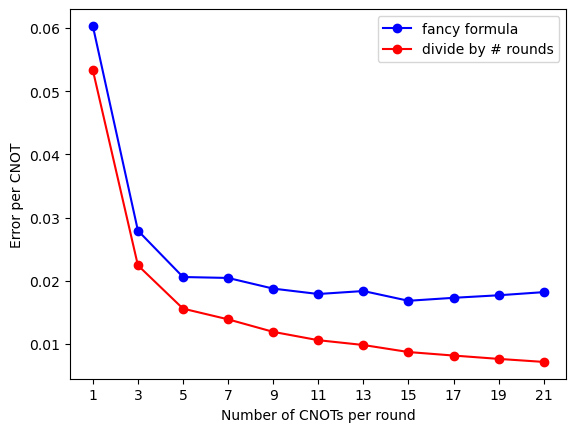

In [4]:
num_rounds = 3
num_cxs_per_round = np.array([1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21])
logical_errors = np.array([0.16, 0.202, 0.234, 0.292, 0.322, 0.35, 0.384, 0.393, 0.4171, 0.436, 0.4517])
errors_per_rounds = .5*(1-(1-logical_errors/.5)**(1/(num_rounds*num_cxs_per_round)))
errors_per_rounds_division = logical_errors / (num_rounds*num_cxs_per_round)
plt.plot(num_cxs_per_round, errors_per_rounds, marker='o', color='blue', label='fancy formula')
plt.plot(num_cxs_per_round, errors_per_rounds_division, marker='o', color='red', label='divide by # rounds')
plt.ylabel('Error per CNOT')
plt.xlabel('Number of CNOTs per round')
plt.xticks(num_cxs_per_round)
plt.legend()
plt.show()

num_layers = 3
num_CX_per_layer = 1
final measurement_index = 146
Preprocessing is done! it took 59.61s
0 [0.025]
infidelity 0.975


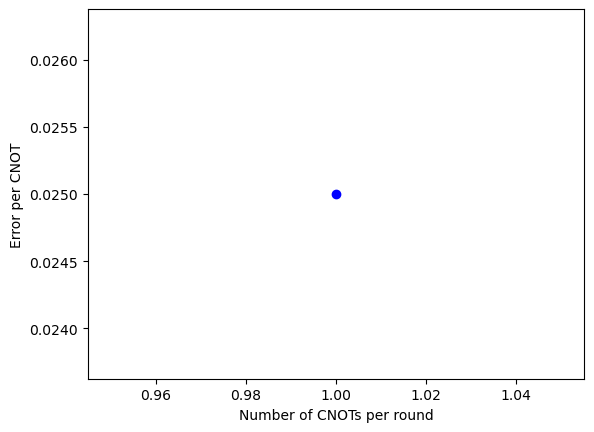

In [4]:
from BiasedErasure.delayed_erasure_decoders.Experimental_Loss_Decoder import *
import numpy as np


num_cxs = np.array([1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21])
num_cxs = np.array([1])
errors = np.array([0.16, 0.202, 0.234, 0.292, 0.322, 0.35, 0.384, 0.393, 0.4171, 0.429, 0.47])
num_rounds = 3
distance = 5
decoder_basis = 'XX'
gate_ordering = ['N', 'Z']


errors = []
for num_cx in num_cxs:
    noise_params = {'idle_loss_rate': 2.793300220405646e-07, 'idle_error_rate': np.array([6.60547942e-09, 3.38336163e-08, 2.67533789e-07]),
                    'entangling_zone_error_rate': np.array([3.66476387e-04, 6.14732819e-06, 2.35857048e-03]),
                    'entangling_gate_error_rate': [2.2260729018707513e-05, 0.00017139584089578063, 0.0012948317242757047, 2.2260729018707513e-05, 0, 0, 0, 0.00017139584089578063, 0, 0, 0, 0.0012948317242757047, 0, 0, 0.002621736717313752],
                    'entangling_gate_loss_rate': 0.00039272255674060926, 'single_qubit_error_rate': np.array([1.53681034e-05, 9.93583065e-04, 1.94650113e-05]),
                    'reset_error_rate': 5.89409983290463e-05, 'measurement_error_rate': 0.0006138700821647161, 'reset_loss_rate': 0.0007531131027610011, 'measurement_loss_rate': 0.07131074481520218, 'ancilla_idle_loss_rate': 1.6989311035347498e-07,
                    'ancilla_idle_error_rate': np.array([1.46727589e-07, 4.60893305e-08, 2.30298714e-06]), 'ancilla_reset_error_rate': 0.024549181355318986, 'ancilla_measurement_error_rate': 0.0012815874700447462, 'ancilla_reset_loss_rate': 0.00019528486460263086, 'ancilla_measurement_loss_rate': 0.00047357577582906143,
                    'gate_noise': LogicalCircuit.ancilla_data_differentiated_gate_noise, 'idle_noise': LogicalCircuit.ancilla_data_differentiated_idle_noise}

    Meta_params = {'architecture': 'CBQC', 'code': 'Rotated_Surface', 'logical_basis': decoder_basis,
                'bias_preserving_gates': 'False',
                'noise': 'atom_array', 'is_erasure_biased': 'False', 'LD_freq': '1000', 'LD_method': 'None',
                'SSR': 'True', 'cycles': str(num_rounds - 1),
                'ordering': gate_ordering,
                'decoder': 'MLE',
                'circuit_type': f'logical_CX_NL{num_rounds}_NCX{num_cx}', 'Steane_type': 'None', 'printing': 'False', 'num_logicals': '2',
                'loss_decoder': 'independent',
                'obs_pos': 'd-1', 'n_r': '0'}


    # Load the experimental measurements
    exp_measurements = np.load('2024_10_15_measurement_events_1CNOT_XX.npy')#[:100, :]
    exp_measurements = np.concatenate([exp_measurements[:, 0, :distance**2-1],
                                       exp_measurements[:, 1, :distance**2-1],
                                       exp_measurements[:, 0, distance**2-1:2*(distance**2-1)],
                                       exp_measurements[:, 1, distance**2-1:2*(distance**2-1)],
                                       exp_measurements[:, 0, 2*(distance**2-1):],
                                       exp_measurements[:, 1, 2*(distance**2-1):]], axis=1)

    # Load the theory circuit
    # theory_measurements, theory_detectors, theory_observables, circuit = get_simulated_measurement_events(Meta_params, distance, distance, 1000, noise_params)
    # print(2 in theory_measurements)
    # Use the theory circuit to get the detection events and observable flips corresponding to the exp data
    # exp_detectors, exp_observables = circuit.compile_m2d_converter().convert(measurements=exp_measurements.astype(bool), separate_observables=True)
    # Find detection event signs
    # exp_detection_events_signs = -np.sign(2*np.nanmean(exp_detectors.astype(int), axis=0)-1).astype(int)

    # Now let's decode!
    use_loss_decoding = True  # if False: use same DEM every shot, without utilizing SSR.
    use_independent_decoder = True  # if False: in every lifecycle, we just apply supercheck at the end. If True: we count the full lifecycle with different potential loss locations and corresponding Clifford propagations.
    use_independent_and_first_comb_decoder = False  # This is relevant only if use_independent_decoder=True. If False: use only independent lifecycles. If True: adds a single combination of lifecycles to the decoder.
    output_dir = '.'
    simulate_data = True
    num_shots = 1000
    # DO IT
    """exp_predictions, exp_observable_flips, dems_list = Loss_MLE_Decoder_Experiment(Meta_params, distance, distance, output_dir,
                                                                        exp_measurements,
                                                                        exp_detection_events_signs, use_loss_decoding,
                                                                        use_independent_decoder,
                                                                        use_independent_and_first_comb_decoder,
                                                                        simulate_data=simulate_data, logical_gaps=False,
                                                                        noise_params=noise_params)
    
    exp_logical_probability = np.mean(np.logical_xor(exp_observable_flips, exp_predictions))"""

    #print('infidelity', 1-exp_logical_probability)
    theory_predictions, theory_observable_flips, dems_list = Loss_MLE_Decoder_Experiment(Meta_params, distance, distance, output_dir,
                                                                        None,
                                                                        None, use_loss_decoding,
                                                                        use_independent_decoder,
                                                                        use_independent_and_first_comb_decoder,
                                                                        simulate_data=simulate_data, logical_gaps=False,
                                                                        noise_params=noise_params, num_shots = num_shots)

    theory_logical_probability = np.mean(np.logical_xor(theory_observable_flips, theory_predictions))
    errors.append(theory_logical_probability)
    print(errors)
    print('infidelity', 1-theory_logical_probability)


plt.plot(num_cxs, errors, marker='o', color='blue')
plt.ylabel('Error per CNOT')
plt.xlabel('Number of CNOTs per round')
plt.show()

In [2]:
## Taking data:

In [2]:
from BiasedErasure.delayed_erasure_decoders.Experimental_Loss_Decoder import *
import numpy as np
# num_rounds = 5

P_dict = {}
P_err_dict = {}
num_shots_dict = {}
num_errors_dict = {}

num_layers_vec = [3,2]
num_cxs_per_round_vec = [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21]
for num_layers in num_layers_vec:
    num_shots_dict[num_layers] = {}
    num_errors_dict[num_layers] = {}
    P_dict[num_layers] = {}
    P_err_dict[num_layers] = {}
    for num_cxs_per_round in num_cxs_per_round_vec:
        distance = 5
        decoder_basis = 'XX'
        gate_ordering = ['N', 'Z']
        noise_params = {'idle_loss_rate': 2.793300220405646e-07, 'idle_error_rate': np.array([6.60547942e-09, 3.38336163e-08, 2.67533789e-07]),
                        'entangling_zone_error_rate': np.array([3.66476387e-04, 6.14732819e-06, 2.35857048e-03]),
                        'entangling_gate_error_rate': [2.2260729018707513e-05, 0.00017139584089578063, 0.0012948317242757047, 2.2260729018707513e-05, 0, 0, 0, 0.00017139584089578063, 0, 0, 0, 0.0012948317242757047, 0, 0, 0.002621736717313752],
                        'entangling_gate_loss_rate': 0.00039272255674060926, 'single_qubit_error_rate': np.array([1.53681034e-05, 9.93583065e-04, 1.94650113e-05]),
                        'reset_error_rate': 5.89409983290463e-05, 'measurement_error_rate': 0.0006138700821647161, 'reset_loss_rate': 0.0007531131027610011, 'measurement_loss_rate': 0.07131074481520218, 'ancilla_idle_loss_rate': 1.6989311035347498e-07,
                        'ancilla_idle_error_rate': np.array([1.46727589e-07, 4.60893305e-08, 2.30298714e-06]), 'ancilla_reset_error_rate': 0.024549181355318986, 'ancilla_measurement_error_rate': 0.0012815874700447462, 'ancilla_reset_loss_rate': 0.00019528486460263086, 'ancilla_measurement_loss_rate': 0.00047357577582906143,
                        'gate_noise': LogicalCircuit.ancilla_data_differentiated_gate_noise, 'idle_noise': LogicalCircuit.ancilla_data_differentiated_idle_noise}



        Meta_params = {'architecture': 'CBQC', 'code': 'Rotated_Surface', 'logical_basis': decoder_basis,
                    'bias_preserving_gates': 'False',
                    'noise': 'atom_array', 'is_erasure_biased': 'False', 'LD_freq': '1000', 'LD_method': 'None',
                    'SSR': 'True', 'cycles': str(num_layers - 1),
                    'ordering': gate_ordering,
                    'decoder': 'MLE',
                    'circuit_type': f'logical_CX_NL{num_layers}_NCX{num_cxs_per_round}', 'Steane_type': 'None', 'printing': 'False', 'num_logicals': '2',
                    'loss_decoder': 'independent',
                    'obs_pos': 'd-1', 'n_r': '0'}



        
        simulate_data = True

        if simulate_data:
            detection_events_signs = None
            measurement_events = None
            num_shots = 5000

        else:
            # Load the experimental measurements
            exp_measurements = np.load(f'/Users/gefenbaranes/Documents/2024_10_15_measurement_events_1CNOT_XX.npy')
            exp_measurements = np.concatenate([exp_measurements[:, 0, :distance**2-1],
                                            exp_measurements[:, 1, :distance**2-1],
                                            exp_measurements[:, 0, distance**2-1:2*(distance**2-1)],
                                            exp_measurements[:, 1, distance**2-1:2*(distance**2-1)],
                                            exp_measurements[:, 0, 2*(distance**2-1):],
                                            exp_measurements[:, 1, 2*(distance**2-1):]], axis=1)
            measurement_events = exp_measurements
            # Load the theory circuit
            _, _, _, circuit = get_simulated_measurement_events(Meta_params, distance, distance, 1, noise_params)
            # Use the theory circuit to get the detection events and observable flips corresponding to the exp data
            detection_events, observable_flips = circuit.compile_m2d_converter().convert(measurements=exp_measurements.astype(bool), separate_observables=True)
            # Find detection event signs
            detection_events_signs = -np.sign(2*np.nanmean(detection_events.astype(int), axis=0)-1).astype(int)

        # Now let's decode!
        use_loss_decoding = True  # if False: use same DEM every shot, without utilizing SSR.
        use_independent_decoder = True  # if False: in every lifecycle, we just apply supercheck at the end. If True: we count the full lifecycle with different potential loss locations and corresponding Clifford propagations.
        use_independent_and_first_comb_decoder = False  # This is relevant only if use_independent_decoder=True. If False: use only independent lifecycles. If True: adds a single combination of lifecycles to the decoder.
        output_dir = '/Users/gefenbaranes/Documents/CX_experiment'
        predictions, observable_flips, dems_list = Loss_MLE_Decoder_Experiment(Meta_params, distance, distance, output_dir,
                                                                            measurement_events,
                                                                            detection_events_signs, use_loss_decoding,
                                                                            use_independent_decoder,
                                                                            use_independent_and_first_comb_decoder,
                                                                            simulate_data=simulate_data, logical_gaps=False,
                                                                            noise_params=noise_params, num_shots=num_shots)
        logical_probability = np.mean(np.logical_xor(observable_flips, predictions))
        num_errors = np.sum(np.logical_xor(observable_flips, predictions))
        logical_probability_error = (np.sqrt(logical_probability*(1-logical_probability)/num_shots))
        print(f'for num_layers = {num_layers}, num_cxs_per_round = {num_cxs_per_round} we get logical error {logical_probability} +- {logical_probability_error}\n')

        
        P_dict[num_layers][num_cxs_per_round] = logical_probability
        P_err_dict[num_layers][num_cxs_per_round] = logical_probability_error
        num_shots_dict[num_layers][num_cxs_per_round] = num_shots
        num_errors_dict[num_layers][num_cxs_per_round] = num_errors



num_layers = 3
num_CX_per_layer = 1
final measurement_index = 146
Preprocessing is done! it took 60.88s
0 1000 2000 3000 4000 for num_layers = 3, num_cxs_per_round = 1 we get logical error 0.0222 +- 0.002083610328252382

num_layers = 3
num_CX_per_layer = 3
final measurement_index = 146


KeyboardInterrupt: 

In [10]:
print(circuit.Pauli_DEM)

AttributeError: 'LogicalCircuit' object has no attribute 'Pauli_DEM'

### with H = Ry:

In [5]:
exp_measurements = np.load(f'/Users/gefenbaranes/Documents/2024_10_15_measurement_events_1CNOT_XX.npy')
exp_measurements = np.concatenate([exp_measurements[:, 0, :distance**2-1],
                                exp_measurements[:, 1, :distance**2-1],
                                exp_measurements[:, 0, distance**2-1:2*(distance**2-1)],
                                exp_measurements[:, 1, distance**2-1:2*(distance**2-1)],
                                exp_measurements[:, 0, 2*(distance**2-1):],
                                exp_measurements[:, 1, 2*(distance**2-1):]], axis=1)
_, _, _, circuit = get_simulated_measurement_events(Meta_params, distance, distance, 1, noise_params)
detection_events, observable_flips = circuit.compile_m2d_converter().convert(measurements=exp_measurements.astype(bool), separate_observables=True)
detection_events_signs_theory = -np.sign(2*np.nanmean(detection_events.astype(int), axis=0)-1).astype(int)
print(detection_events_signs_theory)

detection_events_signs_exp =  np.array([ 1.,  1., -1., -1.,  1.,  1.,  1.,  1., -1., -1.,  1.,  1.,  1.,
        1., -1.,  1.,  1.,  1.,  1., -1., -1., -1.,  1.,  1., -1., -1.,
        1., -1., -1.,  1., -1., -1.,  1., -1., -1.,  1., -1., -1.,  1.,
        1., -1.,  1., -1., -1., -1., -1., -1.,  1.,  1.,  1., -1., -1.,
        1.,  1.,  1.,  1., -1., -1.,  1.,  1., -1., -1., -1.,  1., -1.,
       -1.,  1.,  1., -1., -1.,  1., -1.,  1.,  1., -1., -1.,  1.,  1.,
        1.,  1., -1., -1., -1., -1., -1., -1.,  1.,  1., -1., -1., -1.,
       -1.,  1.,  1., -1., -1.])

print(detection_events_signs_exp)


detection_events_signs_exp - detection_events_signs_theory

num_layers = 3
num_CX_per_layer = 3
final measurement_index = 146
[ 1  1 -1 -1  1  1  1  1 -1 -1  1  1 -1 -1  1 -1  1  1  1 -1  1  1 -1 -1
  1  1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1 -1  1  1  1 -1  1 -1 -1
  1  1 -1 -1  1  1  1  1 -1 -1  1  1  1  1 -1 -1 -1 -1 -1 -1 -1 -1  1  1
  1  1 -1 -1  1  1  1  1 -1 -1 -1 -1 -1 -1  1  1 -1 -1 -1 -1  1  1 -1 -1]
[ 1.  1. -1. -1.  1.  1.  1.  1. -1. -1.  1.  1.  1.  1. -1.  1.  1.  1.
  1. -1. -1. -1.  1.  1. -1. -1.  1. -1. -1.  1. -1. -1.  1. -1. -1.  1.
 -1. -1.  1.  1. -1.  1. -1. -1. -1. -1. -1.  1.  1.  1. -1. -1.  1.  1.
  1.  1. -1. -1.  1.  1. -1. -1. -1.  1. -1. -1.  1.  1. -1. -1.  1. -1.
  1.  1. -1. -1.  1.  1.  1.  1. -1. -1. -1. -1. -1. -1.  1.  1. -1. -1.
 -1. -1.  1.  1. -1. -1.]


array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  2.,
        2., -2.,  2.,  0.,  0.,  0.,  0., -2., -2.,  2.,  2., -2., -2.,
        2.,  0.,  0.,  2.,  0.,  0.,  2.,  0.,  0.,  2.,  0.,  0.,  0.,
        0.,  0.,  0., -2., -2.,  0., -2.,  0.,  2.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -2., -2.,  0.,  2.,  0.,
        0.,  2.,  2.,  0.,  0.,  0., -2.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.])

## with H = Rydagger:

In [2]:
exp_measurements = np.load(f'/Users/gefenbaranes/Documents/2024_10_15_measurement_events_1CNOT_XX.npy')
exp_measurements = np.concatenate([exp_measurements[:, 0, :distance**2-1],
                                exp_measurements[:, 1, :distance**2-1],
                                exp_measurements[:, 0, distance**2-1:2*(distance**2-1)],
                                exp_measurements[:, 1, distance**2-1:2*(distance**2-1)],
                                exp_measurements[:, 0, 2*(distance**2-1):],
                                exp_measurements[:, 1, 2*(distance**2-1):]], axis=1)
_, _, _, circuit = get_simulated_measurement_events(Meta_params, distance, distance, 1, noise_params)
detection_events, observable_flips = circuit.compile_m2d_converter().convert(measurements=exp_measurements.astype(bool), separate_observables=True)
detection_events_signs_theory = -np.sign(2*np.nanmean(detection_events.astype(int), axis=0)-1).astype(int)
print(detection_events_signs_theory)

detection_events_signs_exp =  np.array([ 1.,  1., -1., -1.,  1.,  1.,  1.,  1., -1., -1.,  1.,  1.,  1.,
        1., -1.,  1.,  1.,  1.,  1., -1., -1., -1.,  1.,  1., -1., -1.,
        1., -1., -1.,  1., -1., -1.,  1., -1., -1.,  1., -1., -1.,  1.,
        1., -1.,  1., -1., -1., -1., -1., -1.,  1.,  1.,  1., -1., -1.,
        1.,  1.,  1.,  1., -1., -1.,  1.,  1., -1., -1., -1.,  1., -1.,
       -1.,  1.,  1., -1., -1.,  1., -1.,  1.,  1., -1., -1.,  1.,  1.,
        1.,  1., -1., -1., -1., -1., -1., -1.,  1.,  1., -1., -1., -1.,
       -1.,  1.,  1., -1., -1.])

print(detection_events_signs_exp)


detection_events_signs_exp - detection_events_signs_theory

num_layers = 3
num_CX_per_layer = 3
final measurement_index = 146
[ 1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1  1 -1  1  1  1  1
  1  1  1  1 -1 -1 -1 -1  1  1 -1 -1 -1 -1  1  1 -1  1  1  1 -1  1 -1 -1
  1  1 -1 -1  1  1  1  1 -1 -1  1  1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
  1  1  1  1  1  1  1  1  1  1 -1 -1 -1 -1  1  1 -1 -1 -1 -1  1  1 -1 -1]
[ 1.  1. -1. -1.  1.  1.  1.  1. -1. -1.  1.  1.  1.  1. -1.  1.  1.  1.
  1. -1. -1. -1.  1.  1. -1. -1.  1. -1. -1.  1. -1. -1.  1. -1. -1.  1.
 -1. -1.  1.  1. -1.  1. -1. -1. -1. -1. -1.  1.  1.  1. -1. -1.  1.  1.
  1.  1. -1. -1.  1.  1. -1. -1. -1.  1. -1. -1.  1.  1. -1. -1.  1. -1.
  1.  1. -1. -1.  1.  1.  1.  1. -1. -1. -1. -1. -1. -1.  1.  1. -1. -1.
 -1. -1.  1.  1. -1. -1.]


array([ 0.,  0., -2., -2.,  0.,  0.,  0.,  0., -2., -2.,  0.,  0.,  0.,
        0., -2.,  2.,  0.,  0.,  0.,  0., -2., -2.,  0.,  0., -2., -2.,
        0., -2.,  0.,  2.,  0.,  0.,  0., -2.,  0.,  2.,  0.,  0.,  0.,
        0.,  0.,  0., -2., -2.,  0., -2.,  0.,  2.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  2.,  0.,
        0.,  2.,  2.,  0.,  0.,  2.,  0.,  0.,  0., -2., -2.,  0.,  0.,
        0.,  0., -2., -2.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.])

In [14]:
detection_events_signs_exp = np.array([ 1.,  1., -1., -1.,  1.,  1.,  1.,  1., -1., -1.,  1.,  1.,  1.,
        1., -1.,  1.,  1.,  1.,  1., -1., -1., -1.,  1.,  1., -1., -1.,
        1., -1., -1.,  1., -1., -1.,  1., -1., -1.,  1., -1., -1.,  1.,
        1., -1.,  1., -1., -1., -1., -1., -1.,  1.,  1.,  1., -1., -1.,
        1.,  1.,  1.,  1., -1., -1.,  1.,  1., -1., -1., -1.,  1., -1.,
       -1.,  1.,  1., -1., -1.,  1., -1.,  1.,  1., -1., -1.,  1.,  1.,
        1.,  1., -1., -1., -1., -1., -1., -1.,  1.,  1., -1., -1., -1.,
       -1.,  1.,  1., -1., -1.])

print(detection_events_signs_exp)
exp_measurements = np.load(f'/Users/gefenbaranes/Documents/2024_10_15_measurement_events_1CNOT_XX.npy')
exp_measurements = np.concatenate([exp_measurements[:, 0, :distance**2-1],
                                exp_measurements[:, 1, :distance**2-1],
                                exp_measurements[:, 0, distance**2-1:2*(distance**2-1)],
                                exp_measurements[:, 1, distance**2-1:2*(distance**2-1)],
                                exp_measurements[:, 0, 2*(distance**2-1):],
                                exp_measurements[:, 1, 2*(distance**2-1):]], axis=1)


_, _, _, circuit = get_simulated_measurement_events(Meta_params, distance, distance, 1, noise_params)
# Use the theory circuit to get the detection events and observable flips corresponding to the exp data
detection_events, observable_flips = circuit.compile_m2d_converter().convert(measurements=exp_measurements.astype(bool), separate_observables=True)
# Find detection event signs
detection_events_signs_theory = -np.sign(2*np.nanmean(detection_events.astype(int), axis=0)-1).astype(int)
print(detection_events_signs_theory)


detection_events_signs_theory - detection_events_signs_exp

[ 1.  1. -1. -1.  1.  1.  1.  1. -1. -1.  1.  1.  1.  1. -1.  1.  1.  1.
  1. -1. -1. -1.  1.  1. -1. -1.  1. -1. -1.  1. -1. -1.  1. -1. -1.  1.
 -1. -1.  1.  1. -1.  1. -1. -1. -1. -1. -1.  1.  1.  1. -1. -1.  1.  1.
  1.  1. -1. -1.  1.  1. -1. -1. -1.  1. -1. -1.  1.  1. -1. -1.  1. -1.
  1.  1. -1. -1.  1.  1.  1.  1. -1. -1. -1. -1. -1. -1.  1.  1. -1. -1.
 -1. -1.  1.  1. -1. -1.]
num_CX_per_layer = 3
final measurement_index = 146
[ 1  1 -1 -1  1  1  1  1 -1 -1  1  1 -1 -1  1 -1  1  1  1 -1  1  1 -1 -1
  1  1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1 -1  1  1  1 -1  1 -1 -1
  1  1 -1 -1  1  1  1  1 -1 -1  1  1  1  1 -1 -1 -1 -1 -1 -1 -1 -1  1  1
  1  1 -1 -1  1  1  1  1 -1 -1 -1 -1 -1 -1  1  1 -1 -1 -1 -1  1  1 -1 -1]


array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -2.,
       -2.,  2., -2.,  0.,  0.,  0.,  0.,  2.,  2., -2., -2.,  2.,  2.,
       -2.,  0.,  0., -2.,  0.,  0., -2.,  0.,  0., -2.,  0.,  0.,  0.,
        0.,  0.,  0.,  2.,  2.,  0.,  2.,  0., -2.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  2.,  2.,  0., -2.,  0.,
        0., -2., -2.,  0.,  0.,  0.,  2.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.])

In [2]:
num_shots = 100
# Change #2: a function that doesn't decode, just gives you the measurements, detection events, observables and the circuit:
measurement_events_all_shots, detection_events_all_shots, observable_flips_all_shots, LogicalCircuit = get_simulated_measurement_events(Meta_params, distance, distance, num_shots, noise_params)

num_CX_per_layer = 3
final measurement_index = 146


In [16]:
exp_measurements = np.load(f'/Users/gefenbaranes/Documents/2024_10_15_measurement_events_1CNOT_XX.npy')
measurement_events = np.concatenate([exp_measurements[:, 0, :distance**2-1],
                            exp_measurements[:, 1, :distance**2-1],
                            exp_measurements[:, 0, distance**2-1:2*(distance**2-1)],
                            exp_measurements[:, 1, distance**2-1:2*(distance**2-1)],
                            exp_measurements[:, 0, 2*(distance**2-1):],
                            exp_measurements[:, 1, 2*(distance**2-1):]], axis=1).astype(bool)



detection_events, observable_flips = LogicalCircuit.compile_m2d_converter().convert(measurements=measurement_events, separate_observables=True)
detection_events_signs = -1*np.sign(2*np.nanmean(detection_events.astype(int), axis=0)-1).astype(int)
print(detection_events_signs)



[ 1  1 -1 -1  1  1  1  1 -1 -1  1  1 -1 -1  1 -1  1  1  1 -1  1  1 -1 -1
  1  1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1 -1  1  1  1 -1  1 -1 -1
  1  1 -1 -1  1  1  1  1 -1 -1  1  1  1  1 -1 -1 -1 -1 -1 -1 -1 -1  1  1
  1  1 -1 -1  1  1  1  1 -1 -1 -1 -1 -1 -1  1  1 -1 -1 -1 -1  1  1 -1 -1]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


In [20]:

measurement_events


array([[False, False, False, ..., False,  True, False],
       [False,  True, False, ..., False,  True, False],
       [False, False, False, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True, False],
       [ True,  True, False, ..., False, False,  True],
       [False, False, False, ..., False,  True,  True]])

In [7]:
detection_events_all_shots

detection_events_signs = np.sign(np.nanmean(detection_events_all_shots,axis = -1))

detection_events_signs


array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [16]:
distance = 5
# qubit_states_nans_perlog = np.load('2024_10_15_measurement_events_1CNOT_XX.npy').astype(bool)
qubit_states_nans_perlog = np.load(f'/Users/gefenbaranes/Documents/2024_10_15_measurement_events_1CNOT_XX.npy')
qubit_states_nans_perlog = qubit_states_nans_perlog.transpose(1,2,0)
# exp_measurements = np.concatenate([exp_measurements[:, 0, :distance**2-1],
#                             exp_measurements[:, 1, :distance**2-1],
#                             exp_measurements[:, 0, distance**2-1:2*(distance**2-1)],
#                             exp_measurements[:, 1, distance**2-1:2*(distance**2-1)],
#                             exp_measurements[:, 0, 2*(distance**2-1):],
#                             exp_measurements[:, 1, 2*(distance**2-1):]], axis=1)


perfect_reps = np.ones(qubit_states_nans_perlog.shape[-1]).astype(bool)

In [17]:

num_data_blocks = num_logicals = 2

num_ancilla_blocks = 2
num_rounds = num_ancilla_blocks + 1

ancilla_grid_size = 6
data_grid_size = d = 5
xspc = 3
yspc = 2

num_datas = 25
num_ancillas = 24
total_num_ancillas = num_ancillas*num_ancilla_blocks*num_logicals
total_num_datas = num_datas*num_data_blocks
num_physicals = total_num_ancillas + total_num_datas



stabilizer_weights = np.zeros(num_ancillas)
stabilizer_masks = np.zeros((num_ancillas, num_datas), dtype = bool)

ancilla_Astabs_mask = Zstabs_mask =  np.array([1,1,0,1,0,1,0,0,1,0,1,0,0,1,0,1,0,0,1,0,1,0,1,1], dtype = bool) 
ancilla_Bstabs_mask = Xstabs_mask = (1-ancilla_Astabs_mask).astype(bool)

deterministic_rounds = np.ones(num_rounds).astype(bool)
nondeterministic_rounds = np.array([0] + (num_rounds - 2)*[1] + [0]).astype(bool)


### HARDCODE FOR NOW
stabilizer_weights = np.array([2., 2., 4., 4., 4., 4., 2., 2., 4., 4., 4., 4., 4., 4., 4., 4., 2.,
       2., 4., 4., 4., 4., 2., 2.])
stabilizer_masks = np.array([[1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1]]).astype(bool)


stab2A = (ancilla_Astabs_mask & (stabilizer_weights == 2))
stab2B = (ancilla_Bstabs_mask & (stabilizer_weights == 2))
stab4A = (ancilla_Astabs_mask & (stabilizer_weights == 4))
stab4B = (ancilla_Bstabs_mask & (stabilizer_weights == 4))


vertical_string_masks = np.zeros((d,num_datas)).astype(bool)
horizontal_string_masks = np.zeros((d,num_datas)).astype(bool)

for i in range(d):
    vertical_string_masks[i,i::d] = True
    horizontal_string_masks[i,i*d:d*(i+1)] = True

# qubit_states_nans = atoms_present_final.copy()


# ## Reshape into per logical
# qubit_states_nans_perlog = np.array([qubit_states_nans[logical_qubit_masks[i]] for i in range(num_logicals)])
# qubit_states_perlog = np.nan_to_num(qubit_states_nans_perlog, nan = 3) #convert nan to 3 (so it then becomes 2 in the next line)
# qubit_states_perlog = ((qubit_states_perlog + 1)/2).astype(int)

# data_losses_perlog = np.isnan(qubit_states_nans_perlog[:,-num_datas:])
# data_losses_per_stab_perlog = np.array([np.sum(data_losses_perlog[:,stabilizer_masks[i]], axis = 1) for i in range(num_ancillas)]).transpose(1,0,2)
# num_data_losses_perlog = np.sum(data_losses_perlog, axis = 1)




stabilizer_prod_per_round = []
stabilizer_prod_per_round_withloss = []

loss_sign = +1

for r in range(-1,num_ancilla_blocks):
    if r == -1:
        stab_second = qubit_states_nans_perlog[:,num_ancillas*(r+1):num_ancillas*(r+2)]
        stab_first = np.ones_like(stab_second)
        stab_first_withloss = np.nan_to_num(stab_first,nan = loss_sign)
        stab_second_withloss = np.nan_to_num(stab_second,nan = loss_sign)
                                            
    elif r == num_ancilla_blocks - 1:
        stab_first = qubit_states_nans_perlog[:,num_ancillas*r:num_ancillas*(r+1)]
        stab_first_withloss = np.nan_to_num(stab_first,nan = loss_sign)
        stab_second = np.array([np.prod(qubit_states_nans_perlog[:,-num_datas:][:,stabilizer_masks[i]],axis = 1) for i in range(num_ancillas)]).transpose(1,0,2)
        stab_second_withloss = np.array([np.prod(np.nan_to_num(qubit_states_nans_perlog[:,-num_datas:][:,stabilizer_masks[i]], nan = loss_sign),axis = 1) for i in range(num_ancillas)]).transpose(1,0,2)
    else:
        stab_first = qubit_states_nans_perlog[:,num_ancillas*r:num_ancillas*(r+1)]
        stab_first_withloss = np.nan_to_num(stab_first,nan = loss_sign)
        stab_second = qubit_states_nans_perlog[:,num_ancillas*(r+1):num_ancillas*(r+2)]
        stab_second_withloss = np.nan_to_num(stab_second, nan = loss_sign)

    stab_product_per_round = stab_first*stab_second
    stab_product_per_round_withloss = stab_first_withloss*stab_second_withloss #convert loss to qubit state |0>

    stabilizer_prod_per_round.append(stab_product_per_round)
    stabilizer_prod_per_round_withloss.append(stab_product_per_round_withloss)

stabilizer_prod_per_round = np.array(stabilizer_prod_per_round)
stabilizer_prod_per_round_withloss = np.array(stabilizer_prod_per_round_withloss)

# For sublattice A, and sublattice B separately

error_prob_Astabs = 1-(1+np.abs(np.nanmean(stabilizer_prod_per_round[:,:,ancilla_Astabs_mask],axis = -1)))/2
error_prob_Bstabs = 1-(1+np.abs(np.nanmean(stabilizer_prod_per_round[:,:,ancilla_Bstabs_mask], axis= -1)))/2

error_prob_Astabs_postselected = 1-(1+np.abs(np.nanmean(stabilizer_prod_per_round[:,:,ancilla_Astabs_mask][:,:,:,perfect_reps],axis = -1)))/2
error_prob_Bstabs_postselected = 1-(1+np.abs(np.nanmean(stabilizer_prod_per_round[:,:,ancilla_Bstabs_mask][:,:,:,perfect_reps], axis= -1)))/2

error_prob_Astabs_fully_postselected = np.zeros_like(error_prob_Astabs_postselected)
error_prob_Bstabs_fully_postselected = np.zeros_like(error_prob_Bstabs_postselected)

stabilizer_prod_per_round_per_stab_dataloss_postselection = []
for log in range(num_logicals):
    stabilizer_prod_per_round_per_stab_dataloss_postselection += [[stabilizer_prod_per_round[:,log,i][:,data_losses_per_stab_perlog[log,i] == 0][:,perfect_reps[data_losses_per_stab_perlog[log,i] == 0]] for i in range(num_ancillas)]]
    error_prob_Astabs_fully_postselected[:,log] = 1-(1+np.abs([np.nanmean(stabilizer_prod_per_round_per_stab_dataloss_postselection[-1][i],axis = -1) for i in np.where(ancilla_Astabs_mask)[0]]).T)/2
    error_prob_Bstabs_fully_postselected[:,log] = 1-(1+np.abs([np.nanmean(stabilizer_prod_per_round_per_stab_dataloss_postselection[-1][i],axis = -1) for i in np.where(ancilla_Bstabs_mask)[0]]).T)/2

plt.figure("Detected error per round", figsize = (15,5))
plt.clf()
for log in range(num_logicals):  
    Astab_good_rounds_thislog = deterministic_rounds if prep_basis[log] == 'vertical' else nondeterministic_rounds
    Bstab_good_rounds_thislog = nondeterministic_rounds if prep_basis[log] == 'vertical' else deterministic_rounds
    
    plt.subplot(1,2,log+1)
    plt.bar(np.arange(num_rounds)-0.2,np.nanmean(error_prob_Astabs[:,log],axis = -1),width = 0.4,label = "A", color = "b", alpha = 0.6)
    plt.bar(np.arange(num_rounds)+0.2,np.nanmean(error_prob_Bstabs[:,log],axis = -1),width = 0.4,label = "B", color = "orange", alpha = 0.6)
    plt.bar(np.arange(num_rounds)-0.2,np.nanmean(error_prob_Astabs_postselected[:,log],axis = -1),width = 0.4,label = "A (post)",color = "b")
    plt.bar(np.arange(num_rounds)+0.2,np.nanmean(error_prob_Bstabs_postselected[:,log],axis = -1),width = 0.4,label = "B (post)", color = "orange")
    
    plt.xticks(np.arange(num_rounds))
    plt.xlabel("Round")
    plt.ylabel("Detected error probability")
    plt.ylim(0,0.6)
    plt.legend()
    plt.title(f"""Average error prob (no postselection, exclude loss): {np.nanmean(np.concatenate((error_prob_Astabs[:,log][Astab_good_rounds_thislog],error_prob_Bstabs[:,log][Bstab_good_rounds_thislog]))):.4f}
    Average error prob (postselected, exclude loss): {np.nanmean(np.concatenate((error_prob_Astabs_postselected[:,log][Astab_good_rounds_thislog],error_prob_Bstabs_postselected[:,log][Bstab_good_rounds_thislog]))):.4f}""");

NameError: name 'data_losses_per_stab_perlog' is not defined

In [9]:
error_prob_Astabs_postselected_weight_2 = 1-(1+np.abs(np.nanmean(stabilizer_prod_per_round[:,:,stab2A][:,:,:,perfect_reps],axis = -1)))/2
error_prob_Bstabs_postselected_weight_2  = 1-(1+np.abs(np.nanmean(stabilizer_prod_per_round[:,:,stab2B][:,:,:,perfect_reps], axis= -1)))/2
error_prob_Astabs_postselected_weight_4 = 1-(1+np.abs(np.nanmean(stabilizer_prod_per_round[:,:,stab4A][:,:,:,perfect_reps],axis = -1)))/2
error_prob_Bstabs_postselected_weight_4  = 1-(1+np.abs(np.nanmean(stabilizer_prod_per_round[:,:,stab4B][:,:,:,perfect_reps], axis= -1)))/2

error_prob_Astabs_postselected_weight_2_err = np.nanstd(stabilizer_prod_per_round[:,:,stab2A][:,:,:,perfect_reps],axis = -1)/2/np.sqrt(stabilizer_prod_per_round[:,:,stab2A][:,:,:,perfect_reps].shape[-1])
error_prob_Bstabs_postselected_weight_2_err  = np.nanstd(stabilizer_prod_per_round[:,:,stab2B][:,:,:,perfect_reps], axis= -1)/2/np.sqrt(stabilizer_prod_per_round[:,:,stab2B][:,:,:,perfect_reps].shape[-1])
error_prob_Astabs_postselected_weight_4_err = np.nanstd(stabilizer_prod_per_round[:,:,stab4A][:,:,:,perfect_reps],axis = -1)/2/np.sqrt(stabilizer_prod_per_round[:,:,stab4A][:,:,:,perfect_reps].shape[-1])
error_prob_Bstabs_postselected_weight_4_err  = np.nanstd(stabilizer_prod_per_round[:,:,stab4B][:,:,:,perfect_reps], axis= -1)/2/np.sqrt(stabilizer_prod_per_round[:,:,stab4B][:,:,:,perfect_reps].shape[-1])

stab_mean_prod_stab2A = np.array([np.abs([np.nanmean(stabilizer_prod_per_round_per_stab_dataloss_postselection[log][i],axis = -1) for i in np.where(stab2A)[0]]).T for log in range(num_logicals)]).transpose(1,0,2)
stab_mean_prod_stab2B = np.array([np.abs([np.nanmean(stabilizer_prod_per_round_per_stab_dataloss_postselection[log][i],axis = -1) for i in np.where(stab2B)[0]]).T for log in range(num_logicals)]).transpose(1,0,2)
stab_mean_prod_stab4A = np.array([np.abs([np.nanmean(stabilizer_prod_per_round_per_stab_dataloss_postselection[log][i],axis = -1) for i in np.where(stab4A)[0]]).T for log in range(num_logicals)]).transpose(1,0,2)
stab_mean_prod_stab4B = np.array([np.abs([np.nanmean(stabilizer_prod_per_round_per_stab_dataloss_postselection[log][i],axis = -1) for i in np.where(stab4B)[0]]).T for log in range(num_logicals)]).transpose(1,0,2)

error_prob_Astabs_fully_postselected_weight_2 = 1-(1+np.abs(stab_mean_prod_stab2A))/2
error_prob_Bstabs_fully_postselected_weight_2  = 1-(1+np.abs(stab_mean_prod_stab2B))/2
error_prob_Astabs_fully_postselected_weight_4 = 1-(1+np.abs(stab_mean_prod_stab4A))/2
error_prob_Bstabs_fully_postselected_weight_4  = 1-(1+np.abs(stab_mean_prod_stab4B))/2

error_prob_Astabs_fully_postselected_weight_2_err = np.array([0.5 * np.array([np.nanstd(stabilizer_prod_per_round_per_stab_dataloss_postselection[log][i],axis = -1)/np.sqrt(stabilizer_prod_per_round_per_stab_dataloss_postselection[log][i].shape[-1]) 
                                                                              for i in np.where(stab2A)[0]]).T for log in range(num_logicals)]).transpose(1,0,2)
error_prob_Bstabs_fully_postselected_weight_2_err = np.array([0.5 * np.array([np.nanstd(stabilizer_prod_per_round_per_stab_dataloss_postselection[log][i],axis = -1)/np.sqrt(stabilizer_prod_per_round_per_stab_dataloss_postselection[log][i].shape[-1]) 
                                                                              for i in np.where(stab2B)[0]]).T for log in range(num_logicals)]).transpose(1,0,2)
error_prob_Astabs_fully_postselected_weight_4_err = np.array([0.5 * np.array([np.nanstd(stabilizer_prod_per_round_per_stab_dataloss_postselection[log][i],axis = -1)/np.sqrt(stabilizer_prod_per_round_per_stab_dataloss_postselection[log][i].shape[-1]) 
                                                                              for i in np.where(stab4A)[0]]).T for log in range(num_logicals)]).transpose(1,0,2)
error_prob_Bstabs_fully_postselected_weight_4_err  = np.array([0.5 * np.array([np.nanstd(stabilizer_prod_per_round_per_stab_dataloss_postselection[log][i],axis = -1)/np.sqrt(stabilizer_prod_per_round_per_stab_dataloss_postselection[log][i].shape[-1]) 
                                                                              for i in np.where(stab4B)[0]]).T for log in range(num_logicals)]).transpose(1,0,2)


error_prob_Astabs_postselected_withloss_weight_2  = 1-(1+np.abs(np.mean(stabilizer_prod_per_round_withloss[:,:,stab2A][:,:,:,perfect_reps],axis = -1)))/2
error_prob_Bstabs_postselected_withloss_weight_2  = 1-(1+np.abs(np.mean(stabilizer_prod_per_round_withloss[:,:,stab2B][:,:,:,perfect_reps], axis= -1)))/2
error_prob_Astabs_postselected_withloss_weight_4  = 1-(1+np.abs(np.mean(stabilizer_prod_per_round_withloss[:,:,stab4A][:,:,:,perfect_reps],axis = -1)))/2
error_prob_Bstabs_postselected_withloss_weight_4  = 1-(1+np.abs(np.mean(stabilizer_prod_per_round_withloss[:,:,stab4B][:,:,:,perfect_reps], axis= -1)))/2

array([[1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1,
        0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0,
        0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1,
        0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0,
        0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0,
        1, 0, 0, 1, 0, 0, 0, 1],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1,
        1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
        0, 0, 1, 0, 0, 0, 1, 0],
       [0, 0,

In [ ]:
fig = plt.figure(figsize=(14,10))
fig.subplots_adjust(hspace = 0.4)

for log in range(num_logicals):  
    Astab_good_rounds_thislog = deterministic_rounds if prep_basis[log] == 'vertical' else nondeterministic_rounds
    Bstab_good_rounds_thislog = nondeterministic_rounds if prep_basis[log] == 'vertical' else deterministic_rounds
    
    plt.subplot(num_logicals,2,log*num_logicals + 1)

    plt.plot(np.arange(num_rounds)[Astab_good_rounds_thislog], error_prob_Astabs_postselected_weight_2[Astab_good_rounds_thislog, log],'o--',color='steelblue', alpha = 0.2, zorder = -20)
    plt.plot(np.arange(num_rounds)[Bstab_good_rounds_thislog], error_prob_Bstabs_postselected_weight_2[Bstab_good_rounds_thislog, log],'o--',color='steelblue', alpha = 0.2, zorder = -20)
    plt.plot(np.arange(num_rounds)[Astab_good_rounds_thislog], error_prob_Astabs_postselected_weight_4[Astab_good_rounds_thislog, log],'o--',color='firebrick', alpha = 0.2, zorder = -20)
    plt.plot(np.arange(num_rounds)[Bstab_good_rounds_thislog], error_prob_Bstabs_postselected_weight_4[Bstab_good_rounds_thislog, log],'o--',color='firebrick', alpha = 0.2, zorder = -20)
    plt.plot(np.arange(num_rounds)[Astab_good_rounds_thislog], np.mean(error_prob_Astabs_postselected_weight_2,axis=-1)[Astab_good_rounds_thislog, log],'o-',color='steelblue')
    plt.plot(np.arange(num_rounds)[Bstab_good_rounds_thislog], np.mean(error_prob_Bstabs_postselected_weight_2,axis=-1)[Bstab_good_rounds_thislog, log],'o-',color='steelblue', label='weight 2')
    plt.plot(np.arange(num_rounds)[Astab_good_rounds_thislog], np.mean(error_prob_Astabs_postselected_weight_4,axis=-1)[Astab_good_rounds_thislog, log],'o-',color='firebrick')
    plt.plot(np.arange(num_rounds)[Bstab_good_rounds_thislog], np.mean(error_prob_Bstabs_postselected_weight_4,axis=-1)[Bstab_good_rounds_thislog, log],'o-',color='firebrick', label='weight 4')
    plt.legend(frameon=False)
    plt.ylim(0, 0.5)
    plt.xticks([0,1,2])
    plt.xlabel('QEC cycle')
    plt.ylabel("Detection probability")
    
    all_good_weight2 = np.concatenate((error_prob_Astabs_postselected_weight_2[Astab_good_rounds_thislog, log], error_prob_Bstabs_postselected_weight_2[Bstab_good_rounds_thislog, log])).ravel()
    all_good_weight4 =  np.concatenate((error_prob_Astabs_postselected_weight_4[Astab_good_rounds_thislog, log], error_prob_Bstabs_postselected_weight_4[Bstab_good_rounds_thislog, log])).ravel()
    
    all_good_weight2_err = np.concatenate((error_prob_Astabs_postselected_weight_2_err[Astab_good_rounds_thislog, log], error_prob_Bstabs_postselected_weight_2_err[Bstab_good_rounds_thislog, log])).ravel()
    all_good_weight4_err = np.concatenate((error_prob_Astabs_postselected_weight_4_err[Astab_good_rounds_thislog, log], error_prob_Bstabs_postselected_weight_4_err[Bstab_good_rounds_thislog, log])).ravel()
    
    plt.title(f"""Logical {log+1}: Postselected on rearrangement only
    Weight 2: {np.mean(all_good_weight2):.4f}({np.mean(all_good_weight2_err)/np.sqrt(all_good_weight2.size):.4f}), Weight 4: {np.mean(all_good_weight4):.4f}({np.mean(all_good_weight4_err)/np.sqrt(all_good_weight4.size):.4f})
    Overall {np.mean(np.concatenate((all_good_weight2, all_good_weight4))):.4f}({np.mean(np.concatenate((all_good_weight2_err, all_good_weight4_err)))/np.sqrt(np.concatenate((all_good_weight2, all_good_weight4)).ravel().size):.4f})""")
    
    plt.subplot(num_logicals,2,log*num_logicals + 2)

    plt.plot(np.arange(num_rounds)[Astab_good_rounds_thislog], error_prob_Astabs_fully_postselected_weight_2[Astab_good_rounds_thislog, log],'o--',color='steelblue', alpha = 0.2, zorder = -20)
    plt.plot(np.arange(num_rounds)[Bstab_good_rounds_thislog], error_prob_Bstabs_fully_postselected_weight_2[Bstab_good_rounds_thislog, log],'o--',color='steelblue', alpha = 0.2, zorder = -20)
    plt.plot(np.arange(num_rounds)[Astab_good_rounds_thislog], error_prob_Astabs_fully_postselected_weight_4[Astab_good_rounds_thislog, log],'o--',color='firebrick', alpha = 0.2, zorder = -20)
    plt.plot(np.arange(num_rounds)[Bstab_good_rounds_thislog], error_prob_Bstabs_fully_postselected_weight_4[Bstab_good_rounds_thislog, log],'o--',color='firebrick', alpha = 0.2, zorder = -20)
    plt.plot(np.arange(num_rounds)[Astab_good_rounds_thislog], np.mean(error_prob_Astabs_fully_postselected_weight_2,axis=-1)[Astab_good_rounds_thislog, log],'o-',color='steelblue')
    plt.plot(np.arange(num_rounds)[Bstab_good_rounds_thislog], np.mean(error_prob_Bstabs_fully_postselected_weight_2,axis=-1)[Bstab_good_rounds_thislog, log],'o-',color='steelblue', label='weight 2')
    plt.plot(np.arange(num_rounds)[Astab_good_rounds_thislog], np.mean(error_prob_Astabs_fully_postselected_weight_4,axis=-1)[Astab_good_rounds_thislog, log],'o-',color='firebrick')
    plt.plot(np.arange(num_rounds)[Bstab_good_rounds_thislog], np.mean(error_prob_Bstabs_fully_postselected_weight_4,axis=-1)[Bstab_good_rounds_thislog, log],'o-',color='firebrick', label='weight 4')
    plt.legend(frameon=False)
    plt.ylim(0, 0.5)
    plt.xticks([0,1,2])
    plt.xlabel('QEC cycle')
    plt.ylabel("Detection probability")
    all_good_weight2 = np.concatenate((error_prob_Astabs_fully_postselected_weight_2[Astab_good_rounds_thislog, log], error_prob_Bstabs_fully_postselected_weight_2[Bstab_good_rounds_thislog, log])).ravel()
    all_good_weight4 =  np.concatenate((error_prob_Astabs_fully_postselected_weight_4[Astab_good_rounds_thislog, log], error_prob_Bstabs_fully_postselected_weight_4[Bstab_good_rounds_thislog, log])).ravel()
    
    all_good_weight2_err = np.concatenate((error_prob_Astabs_fully_postselected_weight_2_err[Astab_good_rounds_thislog, log], error_prob_Bstabs_fully_postselected_weight_2_err[Bstab_good_rounds_thislog, log])).ravel()
    all_good_weight4_err = np.concatenate((error_prob_Astabs_fully_postselected_weight_4_err[Astab_good_rounds_thislog, log], error_prob_Bstabs_fully_postselected_weight_4_err[Bstab_good_rounds_thislog, log])).ravel()
    
    plt.title(f"""Logical {log + 1}: Postselected on rearrangement and no data loss
    Weight 2: {np.mean(all_good_weight2):.4f}({np.mean(all_good_weight2_err)/np.sqrt(all_good_weight2.size):.4f}), Weight 4: {np.mean(all_good_weight4):.4f}({np.mean(all_good_weight4_err)/np.sqrt(all_good_weight4.size):.4f})
    Overall {np.mean(np.concatenate((all_good_weight2, all_good_weight4))):.4f}({np.mean(np.concatenate((all_good_weight2_err, all_good_weight4_err)))/np.sqrt(np.concatenate((all_good_weight2, all_good_weight4)).ravel().size):.4f})""")

In [ ]:
for log in np.arange(num_logicals):
    fig, axs = plt.subplots(ancilla_grid_size,ancilla_grid_size)
    # fig.canvas.set_window_title("Ancilla stabilizers, excluding loss")
    fig.subplots_adjust(wspace=0.3,hspace=0.3)
    count = 0
    for i in range(ancilla_grid_size**2):
        ax = axs[i//ancilla_grid_size,i%ancilla_grid_size]
        if ancilla_block_mask[i]:
            mean_stab = np.nanmean(stabilizer_prod_per_round[:,log,count,perfect_reps], axis = -1)
            # ax.bar(np.arange(num_rounds),mean_stab, color = ["r","k"][int(ancilla_Astabs_mask[count])])
            ax.bar(np.arange(num_rounds),mean_stab, color = ["r","k"][int(ancilla_Astabs_mask[count])])
            ax.set_xticks([])
            ax.set_ylim(-1,1)
            count+=1 
        else:
            ax.set_xticks([])
            ax.set_yticks([])
    fig.suptitle("Logical %i stab. products (perfect rearrangement, exclude loss)"%(log+1))


In [9]:
A = 'logical_CX_NL1_NCX2'

print(int(A[13:14]))

print(int(A[18:19]))

1
2
